# Новый Python интерфейс BigARTM.

## Пример №1

Здесь приводится простой пример использования нового пользовательского интерфейса на Python библиотеки BigARTM. Мы будем обучать тематическую модель маленькой коллекции 'kos'.
Для начала подключим все необходимые модули (убедитесь, что путь к artm_model.py находится в вашей переменной PATH):

In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt

import artm.artm_model
from artm.artm_model import *

Первым делом содадим тематическую модель. Новый интерфейс позволяет сделать это в одну строчку:

In [2]:
model = ArtmModel(num_topics=15)

ArtmModel — это объект, содержащий в себе всю информацию о текущем состоянии тематической модели. Все наши последующие действия будут производиться в рамках него. Прежде всего распарсим из файлов 'docword' и 'vocab' в формате UCI, если это необходимо:

In [3]:
if len(glob.glob('kos' + "/*.batch")) < 1:
    model.parse(data_path='', data_format='bow_uci', collection_name='kos')

Следующий шаг — инициализация модели. Сделаем это по словарю, что означает, что
- будет создана матрица Фи с именем 'pwt', число строк и столбцов в ней будет взято исходя из числа слов в словаре и заданного в модели числа тем;
- эа матрица будет заполнена случайными значениями из диапазона (0, 1) и нормализована.

Надо отметить, что этот шаг является опциональным, поскольку модель может быть автоматически инициализирована во время вызовов fit_offline() / fit_online().

In [4]:
model.initialize(dictionary=model.load_dictionary('kos/dictionary'))

ArtmModelпредоставляет возможность использовать все функционалы качества, имеющиеся в BigARTM. Если функционал подключен к модели, то модель будет сохранять все его значения, полученные на момент каждого обновления матрицы Фи.
Для контроля за качеством получаемой модели введём несколько метрик:

In [5]:
model.scores.add(SparsityPhiScore(name='SparsityPhiScore'))
model.scores.add(SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(PerplexityScore(name='PerplexityScore'))

Также полезно добавить несколько базовых регуляризаторов, повышающих разреженность и различность тем (зададим им стартовые коэффициенты регуляризации, которые можно будет позже изменить)

In [6]:
model.regularizers.add(SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
model.regularizers.add(SmoothSparseThetaRegularizer(name='SparseTheta', tau=-2.0))
model.regularizers.add(DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=100000.0))

Теперь попробуем обучить модель в оффлайн-режиме (т.е. обновляя Фи раз за проход по коллекции). Инициируем пять проходов:

In [7]:
model.fit_offline(data_path='kos', num_collection_passes=5)

fit_offline() found 4 batches


Проверим результаты первой итерации обучения:

In [8]:
print 'Sparsity Phi:' + str(model.scores_info['SparsityPhiScore'].last_value)
print 'Sparsity Theta:' + str(model.scores_info['SparsityThetaScore'].last_value)

Sparsity Phi:0.154937735303
Sparsity Theta:0.0457803692906


Видно, что разреженности матриц пока ещё слишком невелики. Попробуем увеличить по модулю значения коэффициентов регуляризации при разреживающих регуляризаторах:

In [9]:
model.regularizers['SparsePhi'].tau = -0.4
model.regularizers['SparseTheta'].tau = -3.0

Также полезно добавить функционал 'TopTokensScore'. Он позволит нам увидеть самые вероятные слова в каждой полученной теме

In [10]:
model.scores.add(TopTokensScore(name='TopTokensScore', num_tokens=5))

Продолжим обучение модели, инициировав 15 проходов по коллекции:

In [11]:
model.fit_offline(data_path='kos', num_collection_passes=15)

fit_offline() found 4 batches


In [12]:
print 'Sparsity Phi:' + str(model.scores_info['SparsityPhiScore'].last_value)
print 'Sparsity Theta:' + str(model.scores_info['SparsityThetaScore'].last_value)

Sparsity Phi:0.783762911478
Sparsity Theta:0.193765792031


Разреженность всё ещё неудовлетворительная. Попробуем ещё усилить разреживание и продолжить обучение:

In [13]:
model.regularizers['SparsePhi'].tau = -1.5
model.regularizers['SparseTheta'].tau = -5.0
model.fit_offline(data_path='kos', num_collection_passes=15)

fit_offline() found 4 batches


Нарисуем графики перплексии и разреженностей:

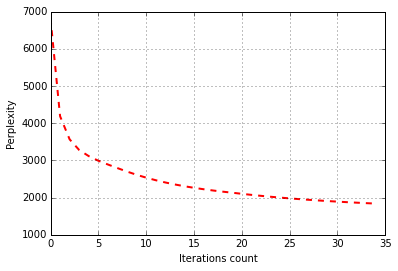

In [14]:
plt.plot(range(model.num_phi_updates), model.scores_info['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Perplexity')
plt.grid(True)
plt.show()

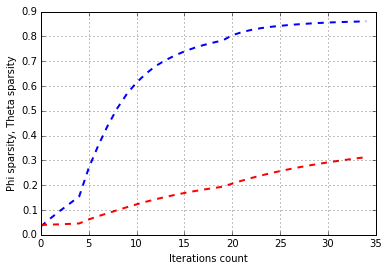

In [15]:
plt.plot(range(model.num_phi_updates), model.scores_info['SparsityPhiScore'].value, 'b--',
         range(model.num_phi_updates), model.scores_info['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Phi sparsity, Theta sparsity')
plt.grid(True)
plt.show()

Для столь маленькой коллекции разреженность достаточная. Напечатаем топовые слова в каждой теме:

In [16]:
for topic_name in model.topic_names:
    print topic_name + ': ',
    print model.scores_info['TopTokensScore'].last_topic_info[topic_name].tokens

@topic_0:  [u'account', u'republicans', u'polls', u'governor', u'voter']
@topic_1:  [u'dean', u'democratic', u'edwards', u'primary', u'clark']
@topic_2:  [u'people', u'issue', u'republicans', u'bill', u'george']
@topic_3:  [u'bush', u'president', u'bushs', u'administration', u'white']
@topic_4:  [u'jobs', u'community', u'time', u'marriage', u'local']
@topic_5:  [u'percent', u'state', u'states', u'million', u'election']
@topic_6:  [u'iraq', u'war', u'iraqi', u'military', u'american']
@topic_7:  [u'delay', u'house', u'committee', u'military', u'texas']
@topic_8:  [u'political', u'media', u'carson', u'conservative', u'campaign']
@topic_9:  [u'news', u'time', u'union', u'media', u'labor']
@topic_10:  [u'kerry', u'poll', u'polls', u'general', u'voters']
@topic_11:  [u'party', u'senate', u'race', u'house', u'republican']
@topic_12:  [u'november', u'electoral', u'senate', u'vote', u'sunzoo']
@topic_13:  [u'administration', u'officials', u'information', u'health', u'security']
@topic_14:  [u't

Последний шаг — сохранение модели. ArtmModel предоставляет две возможности: сохранить модель в формате BigARTM или в .csv файл. 
- в первом случае модель нельзя будет никак визуализировать, но можно загрузить обратно в ArtmModel и продолжить работу с ней;
- .csv файл нельяз загрузить обратно, но на него можно посмотреть глазами.

Воспользуемся обеими возможностями:

In [17]:
model.save(file_name='kos_artm_model')
model.to_csv(file_name='kos_artm_model.csv')

Дополнительно извлечём Тету:

In [18]:
theta_matrix = model.get_theta()

ArtmModel.get_theta() возвращает Теут как объект pandas.DataFrame. Напечатаем её:

In [19]:
print theta_matrix

               1         2         3         4         5         6     \
@topic_0   0.000000  0.000000  0.296327  0.000000  0.000000  0.000000   
@topic_1   0.000000  0.000000  0.000000  0.000000  0.008687  0.000000   
@topic_2   0.055031  0.000000  0.000000  0.027332  0.070590  0.000000   
@topic_3   0.103912  0.000000  0.000000  0.018650  0.189213  0.000000   
@topic_4   0.000000  0.000000  0.000000  0.030813  0.087446  0.000000   
@topic_5   0.112128  0.000000  0.007532  0.006611  0.111909  0.261608   
@topic_6   0.212578  0.223221  0.000000  0.014995  0.058350  0.000000   
@topic_7   0.090176  0.402782  0.000000  0.081300  0.020580  0.000000   
@topic_8   0.128740  0.120044  0.009679  0.623987  0.136699  0.000000   
@topic_9   0.000000  0.000000  0.000000  0.086319  0.065242  0.000000   
@topic_10  0.067925  0.240366  0.016732  0.019211  0.144297  0.660146   
@topic_11  0.118585  0.000000  0.000000  0.063419  0.055680  0.078246   
@topic_12  0.000000  0.000000  0.669730  0.000000  

## Пример №2

Это вторая часть примера использования нового интерфейса библиотеки. Загрузим обратно модель, сохранённую в прошлой части и применим к ней несколько операций.

В первую очередь опять создадим новую тематическую модель:

In [20]:
new_model = ArtmModel(num_processors=2, num_topics=1, num_document_passes=1)

Вторым шагом добавим в неё функционалы и регуляризаторы. Ограничимся одной новой метрикой и двумя уже знакомыми регуляризаторами:

In [21]:
new_model.scores.add(TopicKernelScore(name='TopicKernelScore'))
new_model.regularizers.add(SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1))
new_model.regularizers.add(DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=100000.0))

Теперь загрузим файл 'kos_artm_model' с моделью обратно в библиотеку

In [22]:
new_model.load('kos_artm_model')

Имейте ввиду, что загружаемая модель перепишет несколько параметров нашего объекта ArtmModel: число и имена тем, матрицу Фи. Также загрузка сотрёт всю информацию о данных метрик, посчитанных ранее. Тем не менее, сами подключенные метрики и регуляризаторы никуда не денуться. В нашем случае это функционал 'TopicKernelScore' и регуляризаторы 'SparsePhi' и 'DecorrealtorPhi'.

Теперь продолжим обучение модели, но, для примера, рассмотрим онлайновый режим. Это означает, что
- число проходов по каждому документу увеличивается
- матрица Фи может быть обновлена произвольное количество раз за один проход по коллекции (но не чаще, чем раз за обработанный батч)
- нам требуется только оин проход по коллекции (но здесь мы сделаем 5, поскольку коллекция 'kos' довольно маленькая).

In [23]:
new_model.num_document_passes = 10
for i in range(5):
    new_model.fit_online(data_path='kos', update_every=4)

fit_online() found 4 batches
fit_online() found 4 batches
fit_online() found 4 batches
fit_online() found 4 batches
fit_online() found 4 batches


Параметр 'update_every' говорит модели о том, раз в сколько батчей следует обновлять матрицу Фи.

Выведем средние харакетристики ядер тем (чистоту и контрастность):

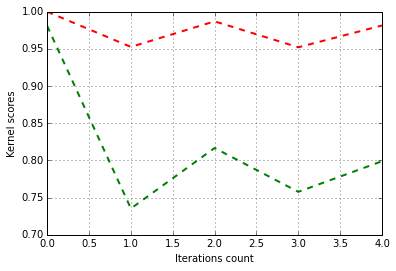

In [24]:
plt.plot(range(new_model.num_phi_updates), new_model.scores_info['TopicKernelScore'].average_contrast, 'g--',
         range(new_model.num_phi_updates), new_model.scores_info['TopicKernelScore'].average_purity, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Kernel scores')
plt.grid(True)
plt.show()

Как мы видим, дальнейшее обучение загруженной модели только ухудшило её качество.

Также можно посмотреть на ифнормацию о ядрах каждой темы. Для примера выведем все ядровые слова первой темы:

In [25]:
print new_model.scores_info['TopicKernelScore'].last_topic_info[new_model.topic_names[0]].tokens

[u'account', u'atlanta', u'attempt', u'barbero', u'bench', u'benson', u'blast', u'bloomfield', u'bob', u'boxblogroll', u'calculator', u'cast', u'casts', u'challenge', u'challenger', u'challengers', u'chedrcheez', u'cities', u'citizen', u'city', u'clock', u'cnn', u'con', u'consistent', u'contact', u'corporate', u'create', u'crooks', u'culture', u'data', u'dem', u'dkosopedia', u'duderino', u'exit', u'falling', u'final', u'francisco', u'ground', u'heart', u'hoodies', u'hotshotxi', u'idetestthispres', u'katerina', u'king', u'kossacks', u'large', u'login', u'man', u'mich', u'midday', u'mike', u'misterajc', u'mosh', u'needed', u'nprigo', u'oceana', u'petraeus', u'photo', u'profile', u'recommended', u'releasing', u'return', u'san', u'sappy', u'save', u'scared', u'slate', u'spindizzy', u'stark', u'steal', u'takes', u'ticket', u'tradesports', u'trouble', u'turnout', u'updated', u'vaantirepublican', u'verification', u'virginiadem', u'voted', u'voter', u'voting', u'west', u'woodward', u'working',

Если у нас есть батч с документами, который не являлся частью обучающей выборки (или являлся, но мы не сохраняли Тету для экономии памяти), и мы хотим узнать столбцы матрицы Теты для него, то следует использовать метод 'find_theta':

In [26]:
test_theta_matrix = model.find_theta(data_path='kos_test', batches=['test_docs.batch'])

ArtmModel.find_theta(), как и ArtmModel.get_theta(), возвращает Тету в виде объекта pandas.DataFrame. Напечатаем ее:

In [27]:
print test_theta_matrix

               3001      3002      3003      3004      3005      3006  \
@topic_0   0.010029  0.046544  0.018492  0.044125  0.054117  0.200978   
@topic_1   0.034398  0.031083  0.038251  0.049749  0.053275  0.023577   
@topic_2   0.072932  0.041588  0.065689  0.053779  0.043178  0.025114   
@topic_3   0.077537  0.044683  0.130908  0.075696  0.084258  0.032617   
@topic_4   0.076735  0.073604  0.089264  0.075005  0.060748  0.015790   
@topic_5   0.088859  0.034658  0.174187  0.102980  0.065022  0.034717   
@topic_6   0.146552  0.036937  0.037460  0.047756  0.073838  0.013536   
@topic_7   0.077916  0.358568  0.057663  0.070827  0.111595  0.028399   
@topic_8   0.061047  0.038317  0.042860  0.077987  0.067100  0.026728   
@topic_9   0.094982  0.038908  0.034815  0.070141  0.085002  0.024558   
@topic_10  0.041359  0.043763  0.137598  0.064385  0.087523  0.045948   
@topic_11  0.049356  0.105231  0.032853  0.143426  0.129099  0.032601   
@topic_12  0.015597  0.024173  0.066916  0.022721  